# DSprites GNN network exploration

In [1]:
cd D:\\Saarbrucken\\EDA_Research\\vae-disentanglement\\disentanglement_lib_pl

D:\Saarbrucken\EDA_Research\vae-disentanglement\disentanglement_lib_pl


In [49]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.offsetbox import OffsetImage, AnnotationBbox
import seaborn as sns
from collections import namedtuple
from matplotlib import cm as mpl_colormaps

import torch
import torchvision.utils as vutils
import torchvision.transforms.functional as T
from torch.utils.data import DataLoader
from torchvision import transforms

from bvae_experiment import BVAEExperiment
from common.data_loader import DSpritesDataset, ThreeShapesDataset, ContinumDataset
from common.notebook_utils import *
import models
from gnncsvae_experiment import GNNCSVAEExperiment
from common.utils import CenteredNorm
# Change figure aesthetics
%matplotlib inline
sns.set_context('talk', font_scale=1.2, rc={'lines.linewidth': 1.5})
np.set_printoptions(suppress=True,precision=4)

In [13]:
# load the learned model here

ModelParams = namedtuple('ModelParams', ["z_dim", "l_dim", "num_labels" , "in_channels", 
                                        "image_size", "batch_size", "w_recon", "w_kld", "kl_warmup_epochs",
                                         "adjacency_matrix", "loss_terms"])

algo_name = "GNNBasedConceptStructuredVAE"
checkpoint_path = r"D:\Saarbrucken\EDA_Research\vae-disentanglement\models-x.ckpt"
z_dim = 2

# prep params
model_params = ModelParams(
        [z_dim], 6, 0, 1, 64, 64, 0.80, 0.15, 0,
    r"D:\Saarbrucken\EDA_Research\vae-disentanglement\adjacency_matrices\dsprites_correlated.pkl", ['aux_classification']
)
exp_params = dict(
        in_channels=1,
        image_size=64,
        LR=1e-4,
        weight_decay=0.0,       
        dataset="dsprites_correlated",
        datapath=r"D:\Saarbrucken\EDA_Research\vae-disentanglement\datasets",
        droplast=True,        
        batch_size=64,
        num_workers=0,
        pin_memory=False,
        seed=123,
        evaluation_metrics=None,
        visdom_on=False,
        save_dir=None,
        max_epochs=1,
        l_zero_reg=False
)

# load model
vae_model_class = getattr(models, algo_name)
vae_model = vae_model_class(model_params)

vae_experiment = GNNCSVAEExperiment.load_from_checkpoint(
            checkpoint_path,
            vae_model=vae_model, 
            params=exp_params,
            dataset_params=dict(correlation_strength=0.2))

# load data
os.environ['DISENTANGLEMENT_LIB_DATA'] = r"D:\Saarbrucken\EDA_Research\vae-disentanglement\datasets"
dataset = get_configured_dataset("dsprites_correlated")
sample_loader = DataLoader(dataset, batch_size=64, shuffle = False, drop_last=True)



tensor([[1., 0., 0., 0., 0.],
        [0., 1., 0., 0., 0.],
        [0., 0., 1., 1., 0.],
        [0., 0., 0., 1., 0.],
        [0., 0., 0., 0., 1.]])
GNNBasedConceptStructuredVAE Model Initialized


Initialize [CorrelatedDSpritesDataset] with 737280 examples. Shape (737280, 64, 64).


In [14]:
def get_latent_activations_with_labels_for_scatter(dataloader, vae_model, curr_dev, z_dim, l_dim, 
                                                    num_nodes, batch_size = 32, batches = None):
   
    B = batches if batches is not None else len(dataloader)
    mu_batches = np.zeros(shape=(batch_size * B, num_nodes, z_dim))
    label_batches = np.zeros(shape=(batch_size * B, l_dim))
    
    batches_processed = 0
    with torch.no_grad():
        for x_batch, label_batch in dataloader:
            
            if batches is not None and batches_processed >= batches:
                break
            
            # First we encode this batch and get \mu and \sigma
            x_batch = x_batch.to(curr_dev)
            
            # posterior_mu has shape (B, V, feat_dim)
            posterior_mu, posterior_logvar, posterior_z = vae_model.model.encode(x_batch)
            
            # convert to numpy format so that we can easily use in matplotlib
            posterior_mu = posterior_mu.detach().cpu().numpy()
            label_batch = label_batch.numpy()
            
            for i in range(batch_size):
                mu_batches[batches_processed*batch_size + i] = posterior_mu[i]
                label_batches[batches_processed*batch_size + i] = label_batch[i]

            batches_processed += 1
        
    return mu_batches, label_batches

In [32]:
curr_dev = torch.device("cuda:0")
l_dim = 5
num_nodes = 5
vae_experiment = vae_experiment.to(curr_dev)

mu_batches, label_batches = get_latent_activations_with_labels_for_scatter(sample_loader, vae_experiment, curr_dev, z_dim, l_dim, 
                                                                           num_nodes, batch_size = 64, batches = 1000)

print(mu_batches.shape, label_batches.shape)

(64000, 5, 2) (64000, 5)


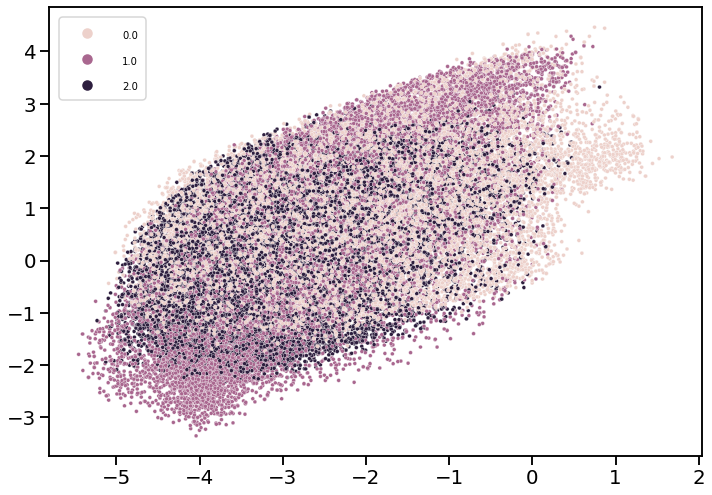

<AxesSubplot:>

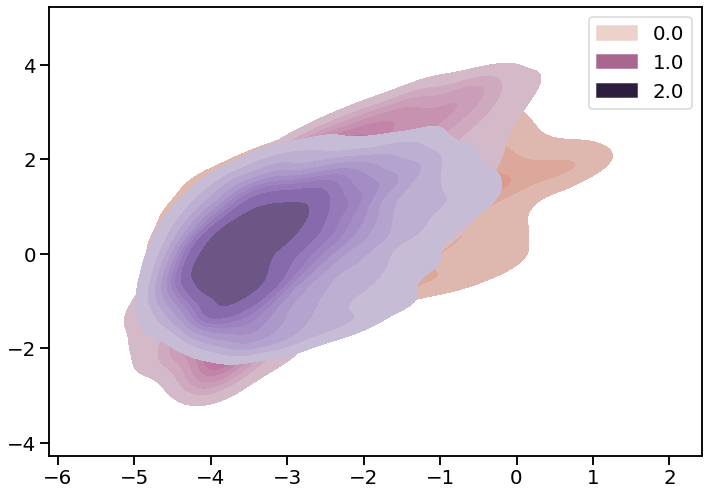

In [40]:
node_idx = 0
fig, ax = plt.subplots()
fig.set_size_inches(11.7, 8.27)
sns.scatterplot(x=mu_batches[:, node_idx, 0], y=mu_batches[:, node_idx, 1], hue=label_batches[:,node_idx], s=15, ax=ax)
plt.setp(ax.get_legend().get_texts(), fontsize='10') # for legend text
plt.show()

fig, ax = plt.subplots()
fig.set_size_inches(11.7, 8.27)
sns.kdeplot(x=mu_batches[:, node_idx, 0],y=mu_batches[:, node_idx, 1], hue=label_batches[:,node_idx], fill=True)

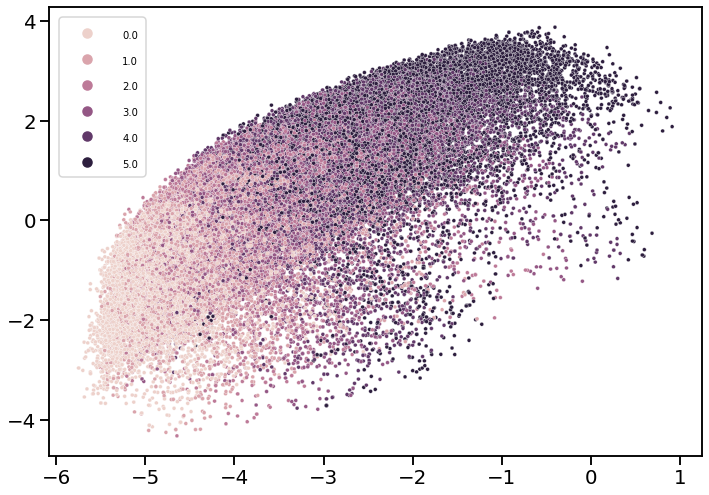

<AxesSubplot:>

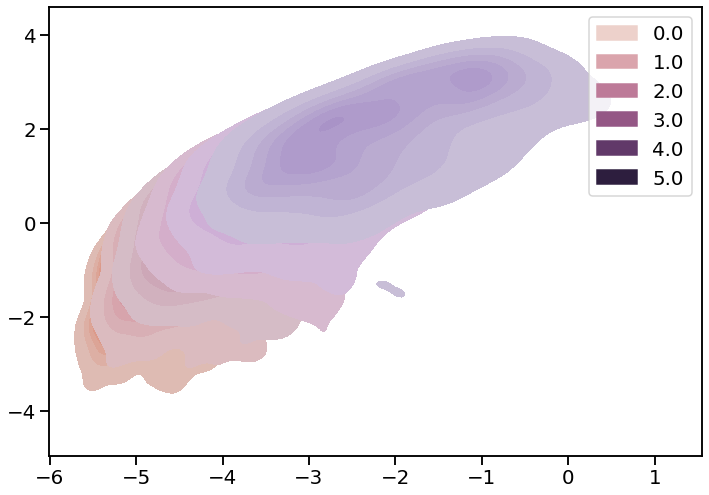

In [41]:
node_idx = 1
fig, ax = plt.subplots()
fig.set_size_inches(11.7, 8.27)
sns.scatterplot(x=mu_batches[:, node_idx, 0], y=mu_batches[:, node_idx, 1], hue=label_batches[:,node_idx], s=15, ax=ax)
plt.setp(ax.get_legend().get_texts(), fontsize='10') # for legend text
plt.show()

fig, ax = plt.subplots()
fig.set_size_inches(11.7, 8.27)
sns.kdeplot(x=mu_batches[:, node_idx, 0],y=mu_batches[:, node_idx, 1], hue=label_batches[:,node_idx], fill=True)

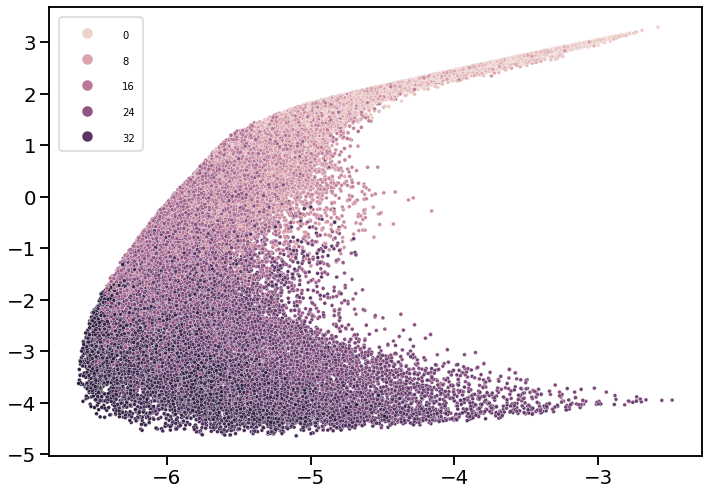

<AxesSubplot:>

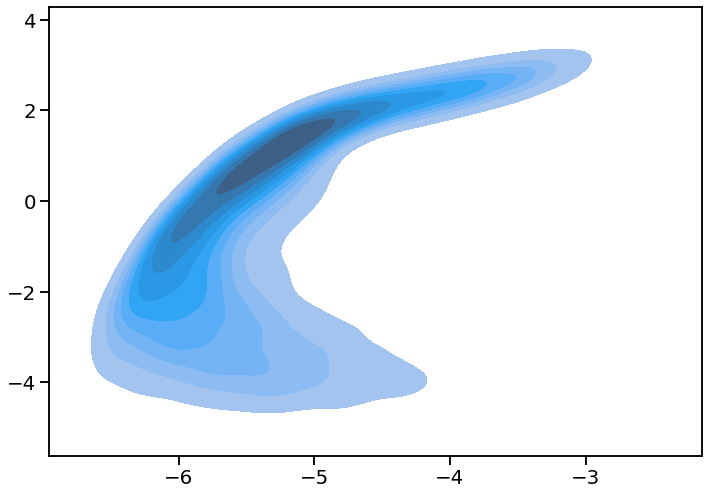

In [47]:
node_idx = 2
fig, ax = plt.subplots()
fig.set_size_inches(11.7, 8.27)
sns.scatterplot(x=mu_batches[:, node_idx, 0], y=mu_batches[:, node_idx, 1], hue=label_batches[:,node_idx], s=15, ax=ax)
plt.setp(ax.get_legend().get_texts(), fontsize='10') # for legend text
plt.show()

fig, ax = plt.subplots()
fig.set_size_inches(11.7, 8.27)
sns.kdeplot(x=mu_batches[:, node_idx, 0],y=mu_batches[:, node_idx, 1], fill=True)


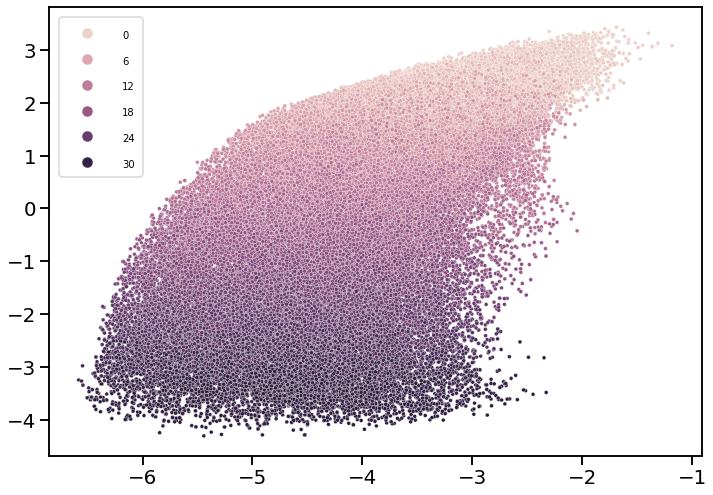

<AxesSubplot:>

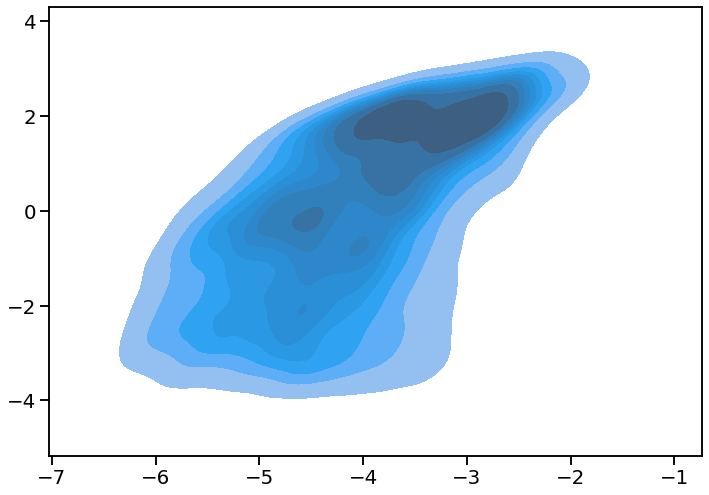

In [43]:
node_idx = 3
fig, ax = plt.subplots()
fig.set_size_inches(11.7, 8.27)
sns.scatterplot(x=mu_batches[:, node_idx, 0], y=mu_batches[:, node_idx, 1], hue=label_batches[:,node_idx], s=15, ax=ax)
plt.setp(ax.get_legend().get_texts(), fontsize='10') # for legend text
plt.show()

fig, ax = plt.subplots()
fig.set_size_inches(11.7, 8.27)
sns.kdeplot(x=mu_batches[:, node_idx, 0],y=mu_batches[:, node_idx, 1], fill=True)

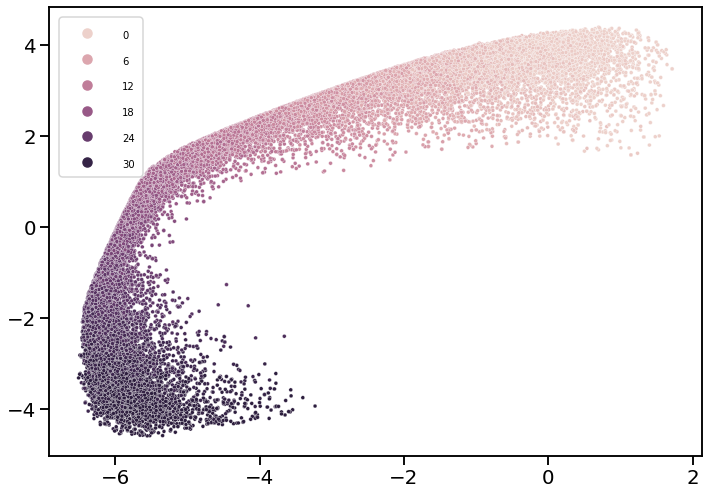

<AxesSubplot:>

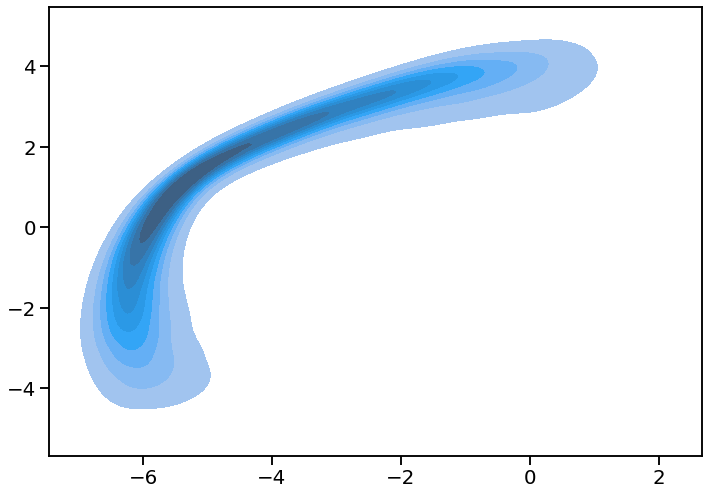

In [44]:
node_idx = 4
fig, ax = plt.subplots()
fig.set_size_inches(11.7, 8.27)
sns.scatterplot(x=mu_batches[:, node_idx, 0], y=mu_batches[:, node_idx, 1], hue=label_batches[:,node_idx], s=15, ax=ax)
plt.setp(ax.get_legend().get_texts(), fontsize='10') # for legend text
plt.show()

fig, ax = plt.subplots()
fig.set_size_inches(11.7, 8.27)
sns.kdeplot(x=mu_batches[:, node_idx, 0],y=mu_batches[:, node_idx, 1], fill=True)

(4, 13)
(4, 13)


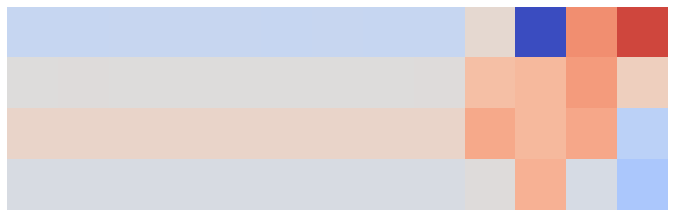

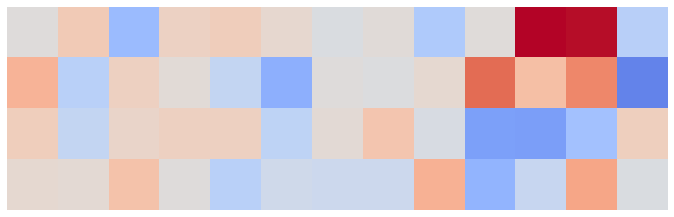

In [50]:
# project mat visualization

Ws = [vae_experiment.model.prior_gnn[i].projection.weight.detach() for i in range(2)]
Ws_to_plot = torch.cat(Ws, dim = 1).cpu().numpy()
print(Ws_to_plot.shape)
fig, axs = plt.subplots(figsize=(10, 6))
fig.tight_layout(pad=0)
axs.margins(0)
plt.axis('off')
plt.imshow(Ws_to_plot, cmap=mpl_colormaps.coolwarm, norm=CenteredNorm())

Ws = [vae_experiment.model.encoder_gnn[i].projection.weight.detach() for i in range(2)]
Ws_to_plot = torch.cat(Ws, dim = 1).cpu().numpy()
print(Ws_to_plot.shape)
fig, axs = plt.subplots(figsize=(10, 6))
fig.tight_layout(pad=0)
axs.margins(0)
plt.axis('off')
plt.imshow(Ws_to_plot, cmap=mpl_colormaps.coolwarm, norm=CenteredNorm())

# Red==positive, Blue==negative